In [1]:
import warnings
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

parent = "notebooks"

try:
    from data_processing import DataProcessor
    from model_evaluation import evaluate_model
    from visualization import DataVisualizer
except ImportError:
    if '__file__' in globals():
        script_dir = os.path.dirname(os.path.abspath(__file__))
        if os.path.basename(script_dir) == 'src':
            project_root = os.path.dirname(script_dir)
        else:
            project_root = script_dir
    else:
        current_dir = os.getcwd()
        project_root = os.path.dirname(current_dir) if current_dir.endswith(parent) else current_dir
    
    src_dir = os.path.join(project_root, 'src')
    if src_dir not in sys.path:
        sys.path.append(src_dir)
    
    from data_processing import DataProcessor
    from visualization import DataVisualization
    from model_evaluation import evaluate_model

if '__file__' in globals():
    script_dir = os.path.dirname(os.path.abspath(__file__))
    if os.path.basename(script_dir) == 'src':
        project_root = os.path.dirname(script_dir)
    else:
        project_root = script_dir
else:
    current_dir = os.getcwd()
    project_root = os.path.dirname(current_dir) if current_dir.endswith(parent) else current_dir

data_dir = os.path.join(project_root, 'data')

cic_pkl_file_name = os.path.join(data_dir, "cic_dataframe.pkl")
cic_file_paths = [
    os.path.join(data_dir, f"CIC/nfstream/{day}-WorkingHours.pcap_nfstream_labeled.csv")
    for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
]

tcpdump_pkl_file_name = os.path.join(data_dir, "tcpdump_dataframe.pkl")
tcpdump_file_paths = [
    os.path.join(data_dir, f"tcpdump/nfstream/{filename}_labeled.csv")
    for filename in [
        "normal_01",
        "normal_02",
        "normal_and_attack_01",
        "normal_and_attack_02",
        "normal_and_attack_03",
        "normal_and_attack_04",
        "normal_and_attack_05",
    ]
]

# Constants
NORMAL_LABEL = 1
ANOMALY_LABEL = -1

# Configuration
test_size = 0.2
random_state = 42
scaled = False
encode_categorical = True
shap_enabled = True
dev_mode = False
corr_threshold = 0.95

In [2]:
if os.path.exists(cic_pkl_file_name):
    print(f"Loading dataframe from {os.path.basename(cic_pkl_file_name)}")
    dataframe = pd.read_pickle(cic_pkl_file_name)
else:
    print(f"Creating dataframe from pcap files and saving to {os.path.basename(cic_pkl_file_name)}")
    dataframe = DataProcessor.get_dataframe(file_paths=cic_file_paths)
    dataframe.to_pickle(cic_pkl_file_name)

Loading dataframe from cic_dataframe.pkl


In [3]:
# selektiere object columns
object_columns = dataframe.select_dtypes(include=['object']).columns.tolist()
if object_columns:
    print(f"Object columns found: {object_columns}")

Object columns found: ['src_ip', 'src_mac', 'src_oui', 'dst_ip', 'dst_mac', 'dst_oui', 'application_name', 'application_category_name', 'requested_server_name', 'client_fingerprint', 'server_fingerprint', 'user_agent', 'content_type', 'label']


In [4]:
for column in object_columns:
    # unique values in the column
    unique_values = dataframe[column].unique()
    print(f"Column '{column}' has {len(unique_values)} unique values")


Column 'src_ip' has 2617 unique values
Column 'src_mac' has 15 unique values
Column 'src_oui' has 8 unique values
Column 'dst_ip' has 18110 unique values
Column 'dst_mac' has 37 unique values
Column 'dst_oui' has 11 unique values
Column 'application_name' has 236 unique values
Column 'application_category_name' has 28 unique values
Column 'requested_server_name' has 25030 unique values
Column 'client_fingerprint' has 57 unique values
Column 'server_fingerprint' has 409 unique values
Column 'user_agent' has 5398 unique values
Column 'content_type' has 60 unique values
Column 'label' has 14 unique values


In [5]:
numric_columns = dataframe.select_dtypes(include=[np.number]).columns.tolist()
len(numric_columns)

73

In [6]:
numeric_cols = dataframe.select_dtypes(include=["number"]).columns
has_inf = any(np.isinf(dataframe[col]).any() for col in numeric_cols)
has_nan = dataframe.isna().any().any()

if has_nan:
    nan_counts = dataframe.isna().sum()
    nan_columns = nan_counts[nan_counts > 0]
    print("\ncoluns with NaN values:")
    print(nan_columns)


coluns with NaN values:
requested_server_name    1447803
client_fingerprint       2612211
server_fingerprint       2614487
user_agent               2634035
content_type             2569986
dtype: int64


In [7]:
# 1a. Load and prepare the data
print("\nStep 1a: Load and prepare the data")
if os.path.exists(cic_pkl_file_name):
    print(f"Loading dataframe from {os.path.basename(cic_pkl_file_name)}")
    dataframe = pd.read_pickle(cic_pkl_file_name)
else:
    print(f"Creating dataframe from pcap files and saving to {os.path.basename(cic_pkl_file_name)}")
    dataframe = DataProcessor.get_dataframe(file_paths=cic_file_paths)
    dataframe.to_pickle(cic_pkl_file_name)

# Add new featueres:
print("Adding new features to the dataframe")
dataframe = DataProcessor.add_new_features(dataframe)

# Drop object columns and handle categorical data
print("Dropping object columns except for some categorical columns")
df_without_object, available_categorical = DataProcessor.drop_object_columns(
            dataframe, encode_categorical=encode_categorical
        )

# Split into features and labels
print("Splitting data into features (X) and labels (y)")
X, y = DataProcessor.split_to_X_y(df_without_object)

# Clean the data
print("Cleaning data")
DataProcessor.clean_data(X)

print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

# Split the data into training and test sets
print(f"Splitting data into train and test sets with test_size={test_size}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, stratify=y
)

# Handle categorical encoding
print("Handling categorical encoding")
X_train, X_test, categorical_encoder = (
    DataProcessor.one_hot_encode_categorical(
        X_train, X_test, available_categorical, None
    )
)

print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")


Step 1a: Load and prepare the data
Loading dataframe from cic_dataframe.pkl
Adding new features to the dataframe
flow rate (bytes/sec and packets/sec)
packet rate (bytes/sec and packets/sec)
Down/Up Ratio
Dropping object columns except for some categorical columns
Retaining categorical features for encoding: ['application_name', 'application_category_name']
Number of columns before dropping object columns: 92
Dropped object columns (11): ['src_ip', 'src_mac', 'src_oui', 'dst_ip', 'dst_mac', 'dst_oui', 'requested_server_name', 'client_fingerprint', 'server_fingerprint', 'user_agent', 'content_type']
Number of columns after dropping object columns: 81
Splitting data into features (X) and labels (y)
Cleaning data
X.shape: (2916222, 80)
y.shape: (2916222,)
Splitting data into train and test sets with test_size=0.2
Handling categorical encoding
Processing categorical features: ['application_name', 'application_category_name']
Creating new OneHotEncoder
Added 261 one-hot encoded features
X_

In [8]:
# 1b. Load and prepare the data
print("\nStep 1b: Load and prepare the data")

print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")

# Scaling the data
if scaled:
    print("Scaleing the data")
    scaler = MinMaxScaler()
    print("New MinMaxScaler instance created")
    X_train = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index,
    )
    X_test = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index,
    )
else:
    scaler = None

# Label conversion
print("Converting labels: benign to 1 and anomalous to -1")
y_train = y_train.map(lambda x: 1 if x == "benign" else -1)
y_test = y_test.map(lambda x: 1 if x == "benign" else -1)

# Feature selection
features_to_drop = DataProcessor.get_features_to_drop()
print(f"Always drop id, src, timestamp...: {features_to_drop}")
X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)
print(f"Droped {len(features_to_drop)} features")


Step 1b: Load and prepare the data
X_train.shape: (2332977, 339)
X_test.shape: (583245, 339)
Converting labels: benign to 1 and anomalous to -1
Always drop id, src, timestamp...: ['id', 'src_port', 'bidirectional_first_seen_ms', 'bidirectional_last_seen_ms', 'src2dst_first_seen_ms', 'src2dst_last_seen_ms', 'dst2src_first_seen_ms', 'dst2src_last_seen_ms']
Droped 8 features


In [9]:
# Correlation matrix
corr_matrix = X_train.corr().abs()

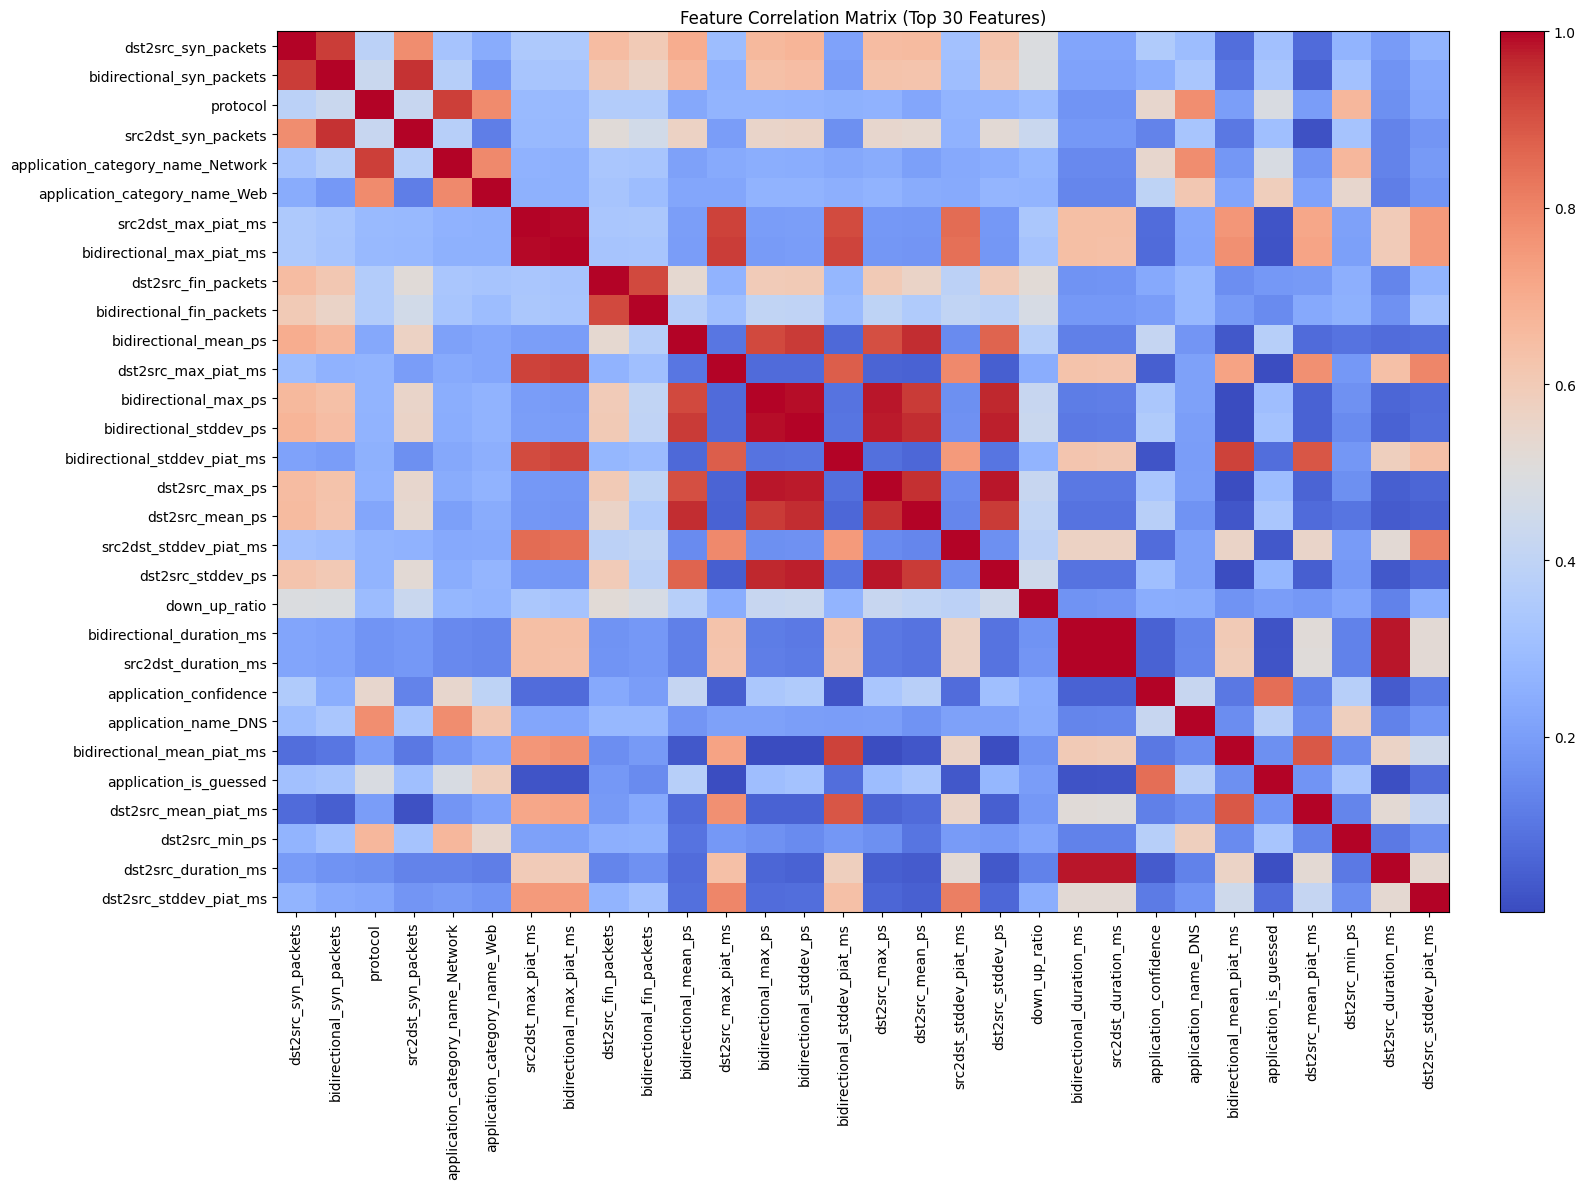


[Sorted] Correlation >= 0.95: 45
application_name_Mining <-> application_category_name_Mining: 1.000
application_name_RPC <-> application_category_name_RPC: 1.000
application_name_TLS.eBay <-> application_category_name_Shopping: 1.000
application_name_Unknown <-> application_category_name_Unspecified: 1.000
bidirectional_packets <-> bidirectional_ack_packets: 1.000
src2dst_packets <-> src2dst_ack_packets: 1.000
dst2src_packets <-> dst2src_ack_packets: 1.000
bidirectional_duration_ms <-> src2dst_duration_ms: 0.998
bidirectional_packets <-> bidirectional_bytes: 0.997
bidirectional_bytes <-> bidirectional_ack_packets: 0.997
bidirectional_max_piat_ms <-> src2dst_max_piat_ms: 0.994
bidirectional_cwr_packets <-> src2dst_cwr_packets: 0.990
bidirectional_ack_packets <-> src2dst_ack_packets: 0.990
bidirectional_packets <-> src2dst_packets: 0.990
src2dst_packets <-> bidirectional_ack_packets: 0.990
bidirectional_packets <-> src2dst_ack_packets: 0.990
bidirectional_stddev_ps <-> bidirectional_ma

In [10]:
plt.figure(figsize=(16, 12))
plt.title("Feature Correlation Matrix (Top 30 Features)")
# visualize the correlation matrix for the top 30 features and save as an image
top_features = corr_matrix.sum().sort_values(ascending=False).head(30).index
sub_corr = corr_matrix.loc[top_features, top_features]
im = plt.imshow(sub_corr, cmap='coolwarm', aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(top_features)), top_features, rotation=90)
plt.yticks(range(len(top_features)), top_features)
plt.tight_layout()
plt.show()
#plt.savefig("correlation_matrix_top30.png", bbox_inches='tight', dpi=200)

# list of highly correlated feature pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] >= corr_threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# sort high_corr_pairs according to correlation value and print them out
high_corr_pairs_sorted = sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)
print("\n[Sorted] Correlation >= {:.2f}: {}".format(corr_threshold, len(high_corr_pairs_sorted)))
for f1, f2, corr in high_corr_pairs_sorted:
    print(f"{f1} <-> {f2}: {corr:.3f}")

In [11]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
to_drop

['bidirectional_bytes',
 'src2dst_duration_ms',
 'src2dst_packets',
 'dst2src_duration_ms',
 'dst2src_packets',
 'bidirectional_max_ps',
 'src2dst_max_ps',
 'dst2src_mean_ps',
 'dst2src_stddev_ps',
 'dst2src_max_ps',
 'src2dst_max_piat_ms',
 'bidirectional_ack_packets',
 'src2dst_syn_packets',
 'src2dst_cwr_packets',
 'src2dst_ece_packets',
 'src2dst_ack_packets',
 'dst2src_ece_packets',
 'dst2src_ack_packets',
 'application_category_name_Download',
 'application_category_name_Game',
 'application_category_name_Mining',
 'application_category_name_RPC',
 'application_category_name_Shopping',
 'application_category_name_Unspecified']

## CIC-Datensatz

In [12]:
cic_datasets = {}
for csv_path in cic_file_paths:
    try:
        filename = os.path.basename(csv_path)
        cic_datasets[filename] = pd.read_csv(csv_path, low_memory=False)
        # trim column names in dataframes
        cic_datasets[filename].columns = cic_datasets[filename].columns.str.strip()
        print(f"CSV file {os.path.basename(csv_path)} exists")
    except FileNotFoundError:
        print(f"CSV file {os.path.basename(csv_path)} does not exist.")
    except pd.errors.EmptyDataError:
        print(f"CSV file {os.path.basename(csv_path)} is empty.")
    except Exception as e:
        print(f"An error occurred while reading {os.path.basename(csv_path)}: {e}")

CSV file Monday-WorkingHours.pcap_nfstream_labeled.csv exists
CSV file Tuesday-WorkingHours.pcap_nfstream_labeled.csv exists
CSV file Wednesday-WorkingHours.pcap_nfstream_labeled.csv exists
CSV file Thursday-WorkingHours.pcap_nfstream_labeled.csv exists
CSV file Friday-WorkingHours.pcap_nfstream_labeled.csv exists


--- Monday-WorkingHours.pcap_nfstream_labeled.csv ---


,label,Count,Percentage
0,benign,630017,100.0



--- Tuesday-WorkingHours.pcap_nfstream_labeled.csv ---


,label,Count,Percentage
0,benign,544442,98.74
1,ftp_patator,3973,0.72
2,ssh_patator,2949,0.53



--- Wednesday-WorkingHours.pcap_nfstream_labeled.csv ---


,label,Count,Percentage
0,benign,564059,74.15
1,dos_hulk,161095,21.18
2,dos_slowloris,13918,1.83
3,dos_slowhttptest,12726,1.67
4,dos_goldeneye,8850,1.16
5,heartbleed,1,0.00



--- Thursday-WorkingHours.pcap_nfstream_labeled.csv ---


,label,Count,Percentage
0,benign,205508,99.03
1,webattack_bruteforce,1354,0.65
2,webattack_xss,657,0.32
3,webattack_sql_injection,9,0.00



--- Friday-WorkingHours.pcap_nfstream_labeled.csv ---


,label,Count,Percentage
0,benign,504931,65.86
1,portscan,155264,20.25
2,ddos,105734,13.79
3,bot,736,0.10


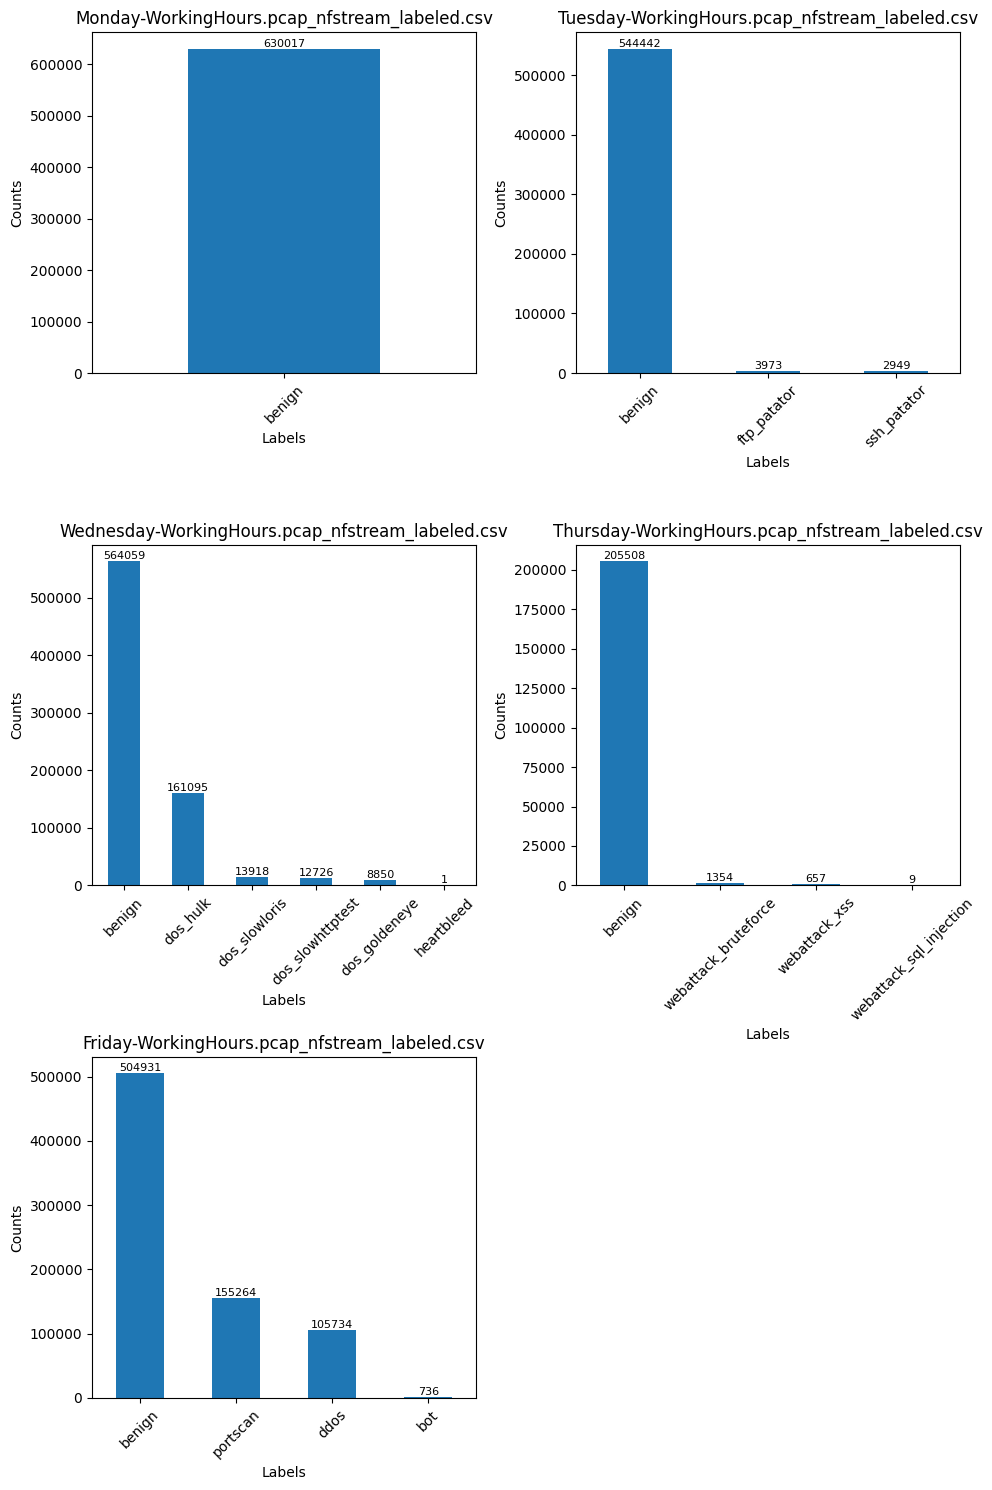

In [13]:
DataVisualization.display_unique_labels(cic_datasets)

## tcpdump-Datensatz

In [14]:
tcpdump_datasets = {}
for csv_path in tcpdump_file_paths:
    try:
        filename = os.path.basename(csv_path)
        tcpdump_datasets[filename] = pd.read_csv(csv_path, low_memory=False)
        # trim column names in dataframes
        tcpdump_datasets[filename].columns = tcpdump_datasets[filename].columns.str.strip()
        print(f"CSV file {os.path.basename(csv_path)} exists")
    except FileNotFoundError:
        print(f"CSV file {os.path.basename(csv_path)} does not exist.")
    except pd.errors.EmptyDataError:
        print(f"CSV file {os.path.basename(csv_path)} is empty.")
    except Exception as e:
        print(f"An error occurred while reading {os.path.basename(csv_path)}: {e}")

CSV file normal_01_labeled.csv exists
CSV file normal_02_labeled.csv exists
CSV file normal_and_attack_01_labeled.csv exists
CSV file normal_and_attack_02_labeled.csv exists
CSV file normal_and_attack_03_labeled.csv exists
CSV file normal_and_attack_04_labeled.csv exists
CSV file normal_and_attack_05_labeled.csv exists


--- normal_01_labeled.csv ---


,label,Count,Percentage
0,benign,12046,100.0



--- normal_02_labeled.csv ---


,label,Count,Percentage
0,benign,24092,100.0



--- normal_and_attack_01_labeled.csv ---


,label,Count,Percentage
0,anomalous,5708,73.75
1,benign,2032,26.25



--- normal_and_attack_02_labeled.csv ---


,label,Count,Percentage
0,anomalous,4036,67.24
1,benign,1966,32.76



--- normal_and_attack_03_labeled.csv ---


,label,Count,Percentage
0,anomalous,4763,70.34
1,benign,2008,29.66



--- normal_and_attack_04_labeled.csv ---


,label,Count,Percentage
0,anomalous,3744,65.78
1,benign,1948,34.22



--- normal_and_attack_05_labeled.csv ---


,label,Count,Percentage
0,anomalous,8859,81.75
1,benign,1978,18.25


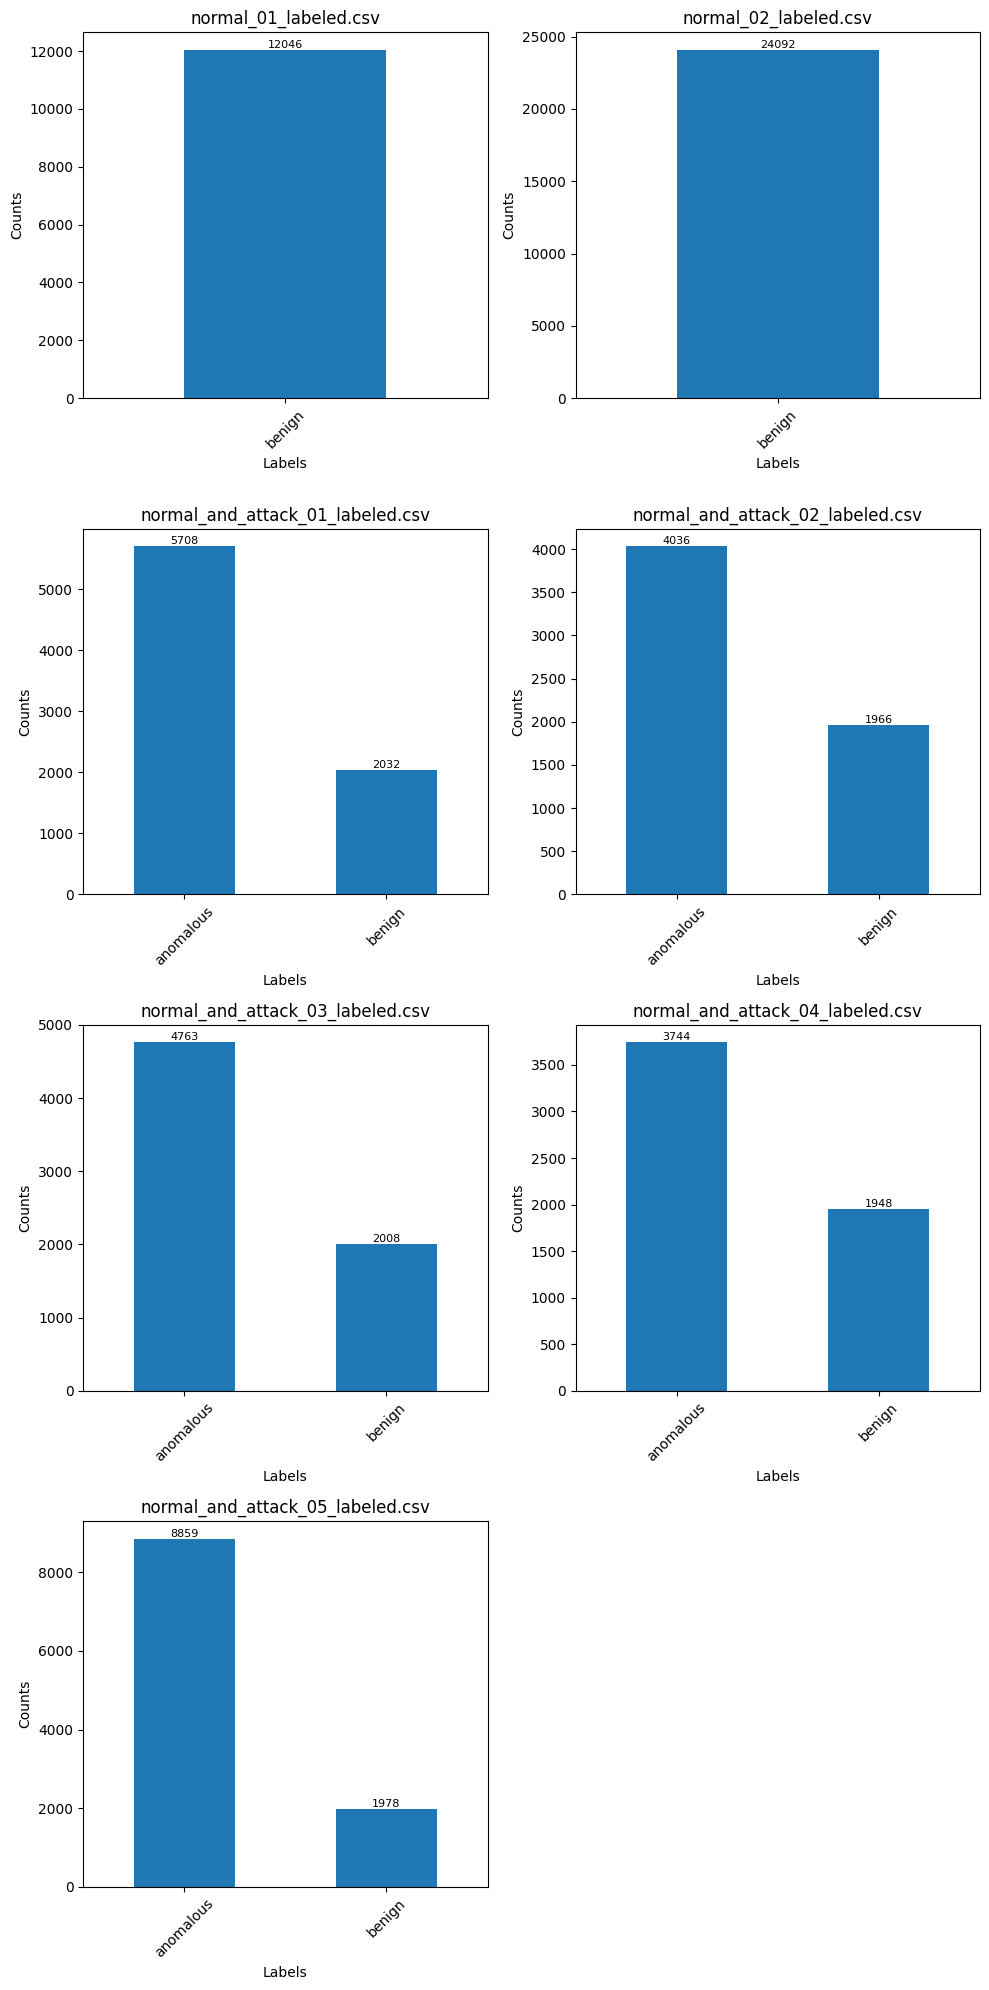

In [15]:
DataVisualization.display_unique_labels(tcpdump_datasets)